In [29]:
#import necessary libraries
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# Importing the dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.head()

,Unnamed: 0,surface_area,agricultural_land,forest_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,inflation_monthly,inflation_weekly,mobile_subscriptions,internet_users,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy
0,0,120540.0,2.632839e+06,5.417843e+06,1379000.0,55.747169,4.688831,unknown,NaN,NaN,NaN,less than 1 per person,0 per 1000 people,NaN,high access,[0%-25%),69.494195
1,1,752610.0,2.403039e+07,4.957554e+07,16500.0,16.890687,23.136313,very low,NaN,0.581473,NaN,less than 1 per person,154 per 1000 people,2.623624e+06,low access,[0%-25%),59.237366
2,2,1396.0,3.000000e+03,8.000000e+01,NaN,18.390090,23.139910,unknown,NaN,NaN,NaN,more than 1 per person,90 per 100 people,1.656589e+09,no info,unknown,81.300000
3,3,2758812.0,1.228845e+08,1.050943e+08,1518650.0,50.966885,24.522427,high,1.374906,NaN,NaN,more than 1 per person,76 per 100 people,6.625072e+08,very high access,[25%-50%),81.373197
4,4,340.0,1.100000e+04,1.699000e+04,NaN,5.311885,30.271115,unknown,-0.044229,NaN,NaN,more than 1 per person,350 per 1000 people,2.832808e+07,very high access,[25%-50%),73.193561


In [4]:
train_df.dtypes

Unnamed: 0                         int64
surface_area                     float64
agricultural_land                float64
forest_area                      float64
armed_forces_total               float64
urban_pop_major_cities           float64
urban_pop_minor_cities           float64
national_income                   object
inflation_annual                 float64
inflation_monthly                float64
inflation_weekly                 float64
mobile_subscriptions              object
internet_users                    object
secure_internet_servers_total    float64
improved_sanitation               object
women_parliament_seats_rate       object
life_expectancy                  float64
dtype: object

In [5]:
train_df.improved_sanitation.value_counts()

improved_sanitation
very high access    155
low access           55
medium access        54
high access          47
very low access      33
no info              18
Name: count, dtype: int64

In [6]:
# Using OrdinalEncoder from sklearn to convert the categories in improved_sanitation to oridinal numbers
categories = ['very high access', 'high access', 'medium access', 'low access', 'very low access', 'no info']
ordinal_encoder = OrdinalEncoder(categories=[categories],unknown_value=None)
# Encoding the 'improved_sanitation' column in both train and test datasets
train_df["improved_sanitation"] = ordinal_encoder.fit_transform(train_df[["improved_sanitation"]])
test_df["improved_sanitation"] = ordinal_encoder.fit_transform(test_df[["improved_sanitation"]])

In [24]:
category_wmn_rate = {"[0%-25%)":1,"[25%-50%)":2,"[50%-75%)":3,"unknown":99}

train_df["women_parliament_seats_rate"].replace(category_wmn_rate, inplace=True)
test_df["women_parliament_seats_rate"].replace(category_wmn_rate,inplace=True)

/tmp/ipykernel_66453/283287226.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["women_parliament_seats_rate"].replace(category_wmn_rate, inplace=True)
/tmp/ipykernel_66453/283287226.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df["women_parliament_seats_rate"].replace(category_wmn_rate,inplace=True)


In [25]:
train_df.women_parliament_seats_rate.value_counts()

women_parliament_seats_rate
1     249
2      82
99     30
3       1
Name: count, dtype: int64

In [7]:
# Create a function to parse the cateogries in internet users into numeric format to use in ML model
def parse_internet_users(val):
    try:
        if isinstance(val, str) and "per" in val:
            parts = val.lower().split("per")
            num = parts[0].strip()
            denom = parts[1].strip().split(" ")[0]
            if num.isdigit() and denom.isdigit():
                return float(num) / float(denom)
            else:
                return None
    except:
        return None

In [8]:
train_df['internet_users_perc'] = train_df['internet_users'].apply(parse_internet_users)
test_df['internet_users_perc'] = test_df['internet_users'].apply(parse_internet_users)

In [9]:
# Create a function to parse the cateogries in mobile subscriptions into numeric format to use in ML model
def parse_mobile_subscriptions(val):
    if val == "more than 1 per person":
        return 1
    elif val == "less than 1 per person":
        return 0
    elif (val == "more than 2 per person" )or (val == "more than 3 per person"):
        return 2
    else:
        return 99
train_df["mobile_subscriptions_num"] = train_df.apply(lambda x: parse_mobile_subscriptions(x['mobile_subscriptions']), axis=1)
test_df["mobile_subscriptions_num"] = test_df.apply(lambda x: parse_mobile_subscriptions(x['mobile_subscriptions']), axis=1)

In [10]:
train_df.national_income.value_counts()
categories_income = ['very low','medium low','low','high','medium high','very high','unknown']
ordinal_encoder_income = OrdinalEncoder(categories=[categories_income], unknown_value=None)
# Encoding the 'national_income' column in both train and test datasets
train_df["national_income"] = ordinal_encoder_income.fit_transform(train_df[["national_income"]])
test_df["national_income"] = ordinal_encoder_income.fit_transform(test_df[["national_income"]])

<Axes: >

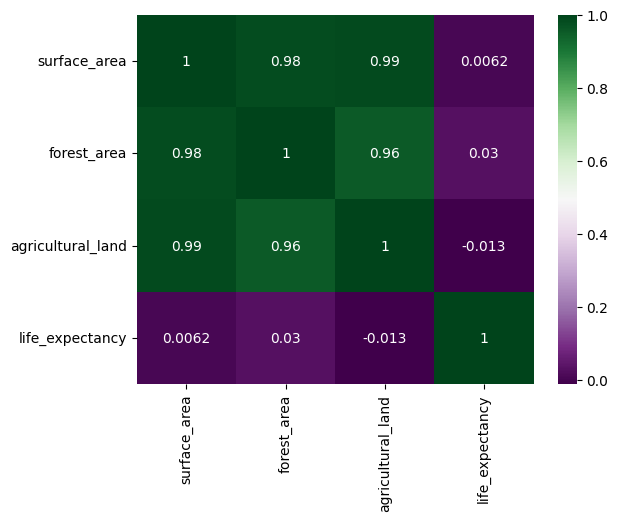

In [11]:
sns.heatmap(train_df[['surface_area','forest_area','agricultural_land','life_expectancy']].corr(),annot=True,cmap='PRGn')

In [12]:
# Value of surface area looks less that agri land and forest area, I was assuming that sum of these two would give surface area.
# Lets create 2 variables ratio of agri land/surface area and forest area/surface area assuming surface area is * 100 or 1000 to get a sense of meaningful ratio.
# The idea is to get what percent of land is agricultural vs forest from the total area available and use it as a feature
train_df["agri_ratio"] = train_df.agricultural_land/(train_df.surface_area*100)
train_df["forest_ratio"] = train_df.forest_area/(train_df.surface_area*100)
test_df["agri_ratio"] = test_df.agricultural_land/(test_df.surface_area*100)
test_df["forest_ratio"] = test_df.forest_area/(test_df.surface_area*100)


In [13]:
train_df.drop(columns=['agricultural_land', 'forest_area'],axis=1,inplace=True)
test_df.drop(columns=['agricultural_land', 'forest_area'],axis=1,inplace=True)

In [14]:
train_df.drop(columns=['mobile_subscriptions','internet_users'],axis=1,inplace=True)
test_df.drop(columns=['mobile_subscriptions','internet_users'],axis=1,inplace=True)

In [15]:
train_df.rename(columns={'Unnamed: 0':'index'},inplace=True)
test_df.rename(columns={'Unnamed: 0':'index'},inplace=True)

In [16]:
# Lot of missing data in inflation columns
# Let's keep inflation_annual column and in places where it's missing lets use weekly and monthly to extrapolate annual numbers

def inflation_annual_func(row):
    if pd.isna(row["inflation_annual"]):
        if pd.isna(row["inflation_monthly"]):
            return 52 * row["inflation_weekly"]
        else:
            return 12 * row["inflation_monthly"]
    else:
        return row["inflation_annual"]
        
train_df["inflation_annual"] = train_df.apply(lambda row: inflation_annual_func(row), axis=1)
test_df["inflation_annual"] = test_df.apply(lambda row: inflation_annual_func(row),axis=1)


In [17]:
train_df.isnull().sum()
train_df.drop(columns=['inflation_monthly','inflation_weekly'],axis=1,inplace=True)
test_df.drop(columns=['inflation_monthly','inflation_weekly'],axis=1,inplace=True)

In [19]:
# Check for missing information again
num_imputer = SimpleImputer(strategy="median")
train_df[["armed_forces_total", "inflation_annual","secure_internet_servers_total","internet_users_perc","forest_ratio","agri_ratio","urban_pop_major_cities","urban_pop_minor_cities"]] = num_imputer.fit_transform(train_df[["armed_forces_total", "inflation_annual","secure_internet_servers_total","internet_users_perc","forest_ratio","agri_ratio","urban_pop_major_cities","urban_pop_minor_cities"]])
test_df[["armed_forces_total", "inflation_annual","secure_internet_servers_total","internet_users_perc","forest_ratio","agri_ratio","urban_pop_major_cities","urban_pop_minor_cities"]] = num_imputer.fit_transform(test_df[["armed_forces_total", "inflation_annual","secure_internet_servers_total","internet_users_perc","forest_ratio","agri_ratio","urban_pop_major_cities","urban_pop_minor_cities"]])


In [26]:
# Check for missing information
train_df.isnull().sum().sort_values(ascending=False)

index                            0
surface_area                     0
armed_forces_total               0
urban_pop_major_cities           0
urban_pop_minor_cities           0
national_income                  0
inflation_annual                 0
secure_internet_servers_total    0
improved_sanitation              0
women_parliament_seats_rate      0
life_expectancy                  0
internet_users_perc              0
mobile_subscriptions_num         0
agri_ratio                       0
forest_ratio                     0
dtype: int64

In [20]:
train_df

,index,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy,internet_users_perc,mobile_subscriptions_num,agri_ratio,forest_ratio
0,0,120540.0,1379000.0,55.747169,4.688831,6.0,3.371067,2.671228e+07,1.0,[0%-25%),69.494195,0.000,0,0.218420,0.449464
1,1,752610.0,16500.0,16.890687,23.136313,0.0,6.977676,2.623624e+06,3.0,[0%-25%),59.237366,0.154,0,0.319294,0.658715
2,2,1396.0,53525.0,18.390090,23.139910,6.0,3.371067,1.656589e+09,5.0,unknown,81.300000,0.900,1,0.021490,0.000573
3,3,2758812.0,1518650.0,50.966885,24.522427,3.0,1.374906,6.625072e+08,0.0,[25%-50%),81.373197,0.760,1,0.445426,0.380940
4,4,340.0,53525.0,5.311885,30.271115,6.0,-0.044229,2.832808e+07,0.0,[25%-50%),73.193561,0.350,1,0.323529,0.499706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,457,243610.0,159150.0,42.818424,39.273576,3.0,2.554547,1.193275e+09,0.0,[0%-25%),80.956098,0.900,1,0.713024,0.128550
358,458,9831510.0,1433150.0,22.948363,58.328637,5.0,1.464833,1.304449e+09,0.0,[0%-25%),78.841463,0.840,0,0.443226,0.338396
359,459,176220.0,25450.0,92.409069,2.573931,4.0,8.575135,7.511805e+07,0.0,[0%-25%),76.836195,0.580,1,0.820649,0.102818
360,460,330972.0,522000.0,27.411815,4.897185,2.0,6.592256,8.159726e+06,2.0,[0%-25%),75.756488,0.440,1,0.350685,0.468120


In [55]:
train_df_X = train_df.drop(columns=['index', 'life_expectancy'])
train_df_y = train_df['life_expectancy']
Xtrain, Xtest, ytrain, ytest = train_test_split(train_df_X, train_df_y, test_size=0.3, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Features and target variable

X_test = test_df.drop(columns=['index'])
# Fit the model
model.fit(Xtrain, ytrain)

RandomForestRegressor(random_state=42)

In [62]:
y_pred = model.predict(Xtest)
print("MAE:", mean_absolute_error(ytest, y_pred))
print("R2 Score:", r2_score(ytest, y_pred))

MAE: 2.5438620269853205
R2 Score: 0.7905922900757377


In [64]:
test_df

,index,surface_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,internet_users_perc,mobile_subscriptions_num,agri_ratio,forest_ratio
0,9,322460.0,50800.0,0.846584,51.919416,2.0,2.569961,1849926.0,4.0,1,0.084,0,0.647799,0.327101
1,16,513120.0,453550.0,42.139810,5.803190,2.0,2.184886,17983312.0,0.0,1,0.289,1,0.432774,0.319814
2,19,18580.0,50800.0,1.699056,67.396944,6.0,3.009844,240458015.0,0.0,99,0.660,0,0.100766,0.458972
3,23,112490.0,20000.0,48.602426,4.934574,2.0,5.161899,9427882.0,1.0,1,0.178,0,0.289123,0.431853
4,28,783560.0,612800.0,43.734006,28.635994,1.0,7.493090,50379814.0,0.0,1,0.460,0,0.499240,0.149555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,433,1267000.0,10700.0,10.700246,7.519754,0.0,2.298522,163409.0,4.0,1,0.017,0,0.353533,0.009211
96,441,11610.0,11800.0,97.972567,1.088433,5.0,3.131571,167040406.0,0.0,1,0.850,1,0.058234,0.000000
97,443,2840.0,50800.0,6.639330,12.800670,2.0,0.610086,26261884.0,0.0,1,0.153,0,0.123675,0.604240
98,453,142550.0,16300.0,19.272272,7.348728,0.0,3.009844,1232758.0,0.0,1,0.160,0,0.348314,0.029380


In [67]:
predictions = model.predict(test_df.drop(columns=["index"]))
pred_df = pd.DataFrame(predictions, columns=["Predicted_Life_Expectancy"])
pred_df["index"] = test_df["index"]
pred_df[["index","Predicted_Life_Expectancy"]]

,index,Predicted_Life_Expectancy
0,9,61.734125
1,16,72.321945
2,19,76.921042
3,23,70.116171
4,28,74.787302
...,...,...
95,433,54.195286
96,441,77.282474
97,443,71.633685
98,453,69.973806


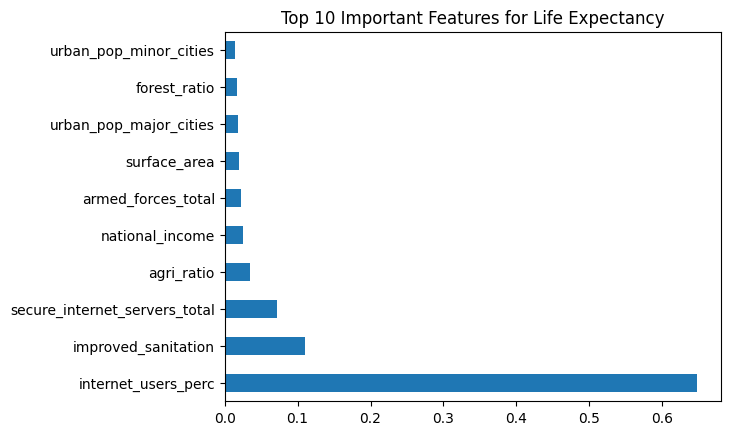

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance
importances = pd.Series(model.feature_importances_, index=train_df_X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features for Life Expectancy")
plt.show()
